🗺️ Análisis NDVI con Shapefiles

📦 Shapefile cargado: aoi_parcela.shp
   Número de parcelas: 1
   CRS original: EPSG:4326
   Columnas: ['id', 'geometry']

Parcelas encontradas:
   Parcela 0: Parcela_0

✓ Geometría convertida a formato Earth Engine

🛰️ Descargando imagen Sentinel-2...
   Imágenes disponibles: 6
   ✓ NDVI calculado exitosamente

📊 Extrayendo estadísticas NDVI por parcela...
   Parcela_0: NDVI promedio = 0.473

🗺️ Creando mapa interactivo...
   ✓ Mapa guardado como 'mapa_ndvi_shapefile.html'


Map(center=[8.88650004513493, -75.87649999999688], controls=(WidgetControl(options=['position', 'transparent_b…


📈 Generando gráficos...


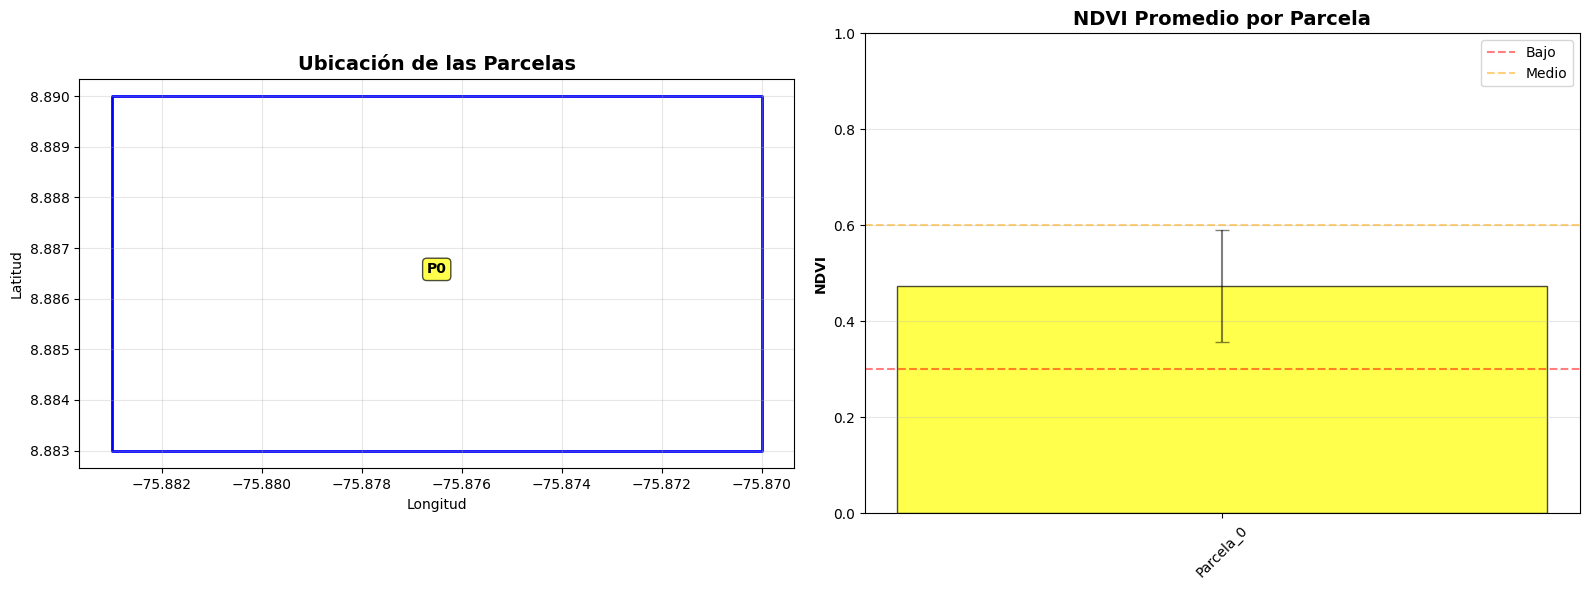


📋 ESTADÍSTICAS NDVI POR PARCELA
Parcela              Promedio     Mín        Máx        Desv.Est  
------------------------------------------------------------
Parcela_0                 0.473       0.104       0.881       0.117

✓ Análisis completado
✓ Mapa interactivo disponible en 'mapa_ndvi_shapefile.html'


In [1]:
# NDVI Analysis Using Google Earth Engine and Shapefiles

%matplotlib inline

import ee
import geemap
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import mapping

# Inicializar Earth Engine
ee.Initialize(project='agtech-suscripci-1759332935027')

print("🗺️ Análisis NDVI con Shapefiles")
print("="*60)

## 1. Cargar el shapefile de las parcelas
shapefile_path = "aoi_parcela.shp"
parcelas_gdf = gpd.read_file(shapefile_path)

print(f"\n📦 Shapefile cargado: {shapefile_path}")
print(f"   Número de parcelas: {len(parcelas_gdf)}")
print(f"   CRS original: {parcelas_gdf.crs}")
print(f"   Columnas: {list(parcelas_gdf.columns)}")

# Convertir a WGS84 si es necesario (requerido por GEE)
if parcelas_gdf.crs != 'EPSG:4326':
    parcelas_gdf = parcelas_gdf.to_crs('EPSG:4326')
    print(f"   CRS convertido a: EPSG:4326")

# Mostrar información de las parcelas
print("\nParcelas encontradas:")
for idx, row in parcelas_gdf.iterrows():
    print(f"   Parcela {idx}: {row.get('name', row.get('Name', f'Parcela_{idx}'))}")

## 2. Convertir shapefile a geometría de Earth Engine
def gdf_to_ee_geometry(gdf):
    """Convierte un GeoDataFrame a una geometría de Earth Engine"""
    geom_list = []
    for idx, row in gdf.iterrows():
        geom_json = mapping(row.geometry)
        geom_list.append(ee.Geometry(geom_json))
    
    if len(geom_list) == 1:
        return geom_list[0]
    else:
        return ee.FeatureCollection([ee.Feature(g) for g in geom_list]).geometry()

aoi_ee = gdf_to_ee_geometry(parcelas_gdf)
print("\n✓ Geometría convertida a formato Earth Engine")

## 3. Obtener imagen Sentinel-2 y calcular NDVI
print("\n🛰️ Descargando imagen Sentinel-2...")

# Fecha de análisis
start_date = '2023-01-01'
end_date = '2023-06-30'

# Cargar colección Sentinel-2
s2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED').filterDate(start_date, end_date).filterBounds(aoi_ee).filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)).select(['B4', 'B8', 'B2', 'B3'])

# Verificar si hay imágenes disponibles
count = s2.size().getInfo()
print(f"   Imágenes disponibles: {count}")

if count > 0:
    # Obtener imagen mediana (reduce nubes)
    s2_median = s2.median().clip(aoi_ee)
    
    # Calcular NDVI
    ndvi = s2_median.normalizedDifference(['B8', 'B4']).rename('NDVI')
    
    # Imagen RGB para contexto
    rgb = s2_median.select(['B4', 'B3', 'B2'])
    
    print("   ✓ NDVI calculado exitosamente")
    
    ## 4. Extraer estadísticas NDVI por parcela
    print("\n📊 Extrayendo estadísticas NDVI por parcela...")
    
    stats_list = []
    for idx, row in parcelas_gdf.iterrows():
        parcela_name = row.get('name', row.get('Name', f'Parcela_{idx}'))
        parcela_geom = ee.Geometry(mapping(row.geometry))
        
        # Calcular estadísticas
        stats = ndvi.reduceRegion(
            reducer=ee.Reducer.mean().combine(
                reducer2=ee.Reducer.min(), 
                sharedInputs=True
            ).combine(
                reducer2=ee.Reducer.max(), 
                sharedInputs=True
            ).combine(
                reducer2=ee.Reducer.stdDev(), 
                sharedInputs=True
            ),
            geometry=parcela_geom,
            scale=10,
            maxPixels=1e9
        ).getInfo()
        
        stats_list.append({
            'Parcela': parcela_name,
            'NDVI_Promedio': stats.get('NDVI_mean', None),
            'NDVI_Min': stats.get('NDVI_min', None),
            'NDVI_Max': stats.get('NDVI_max', None),
            'NDVI_StdDev': stats.get('NDVI_stdDev', None)
        })
        
        print(f"   {parcela_name}: NDVI promedio = {stats.get('NDVI_mean', 0):.3f}")
    
    ## 5. Crear mapa interactivo con geemap
    print("\n🗺️ Creando mapa interactivo...")
    
    Map = geemap.Map(ee_initialize=False, basemap='HYBRID')
    Map.centerObject(aoi_ee, 14)
    
    # Parámetros de visualización
    ndvi_vis = {
        'min': 0,
        'max': 1,
        'palette': ['red', 'yellow', 'green']
    }
    
    rgb_vis = {
        'min': 0,
        'max': 3000,
        'bands': ['B4', 'B3', 'B2']
    }
    
    # Agregar capas
    Map.addLayer(rgb, rgb_vis, 'Sentinel-2 RGB', False)
    Map.addLayer(ndvi, ndvi_vis, 'NDVI')
    
    # Agregar shapefile
    style = {'color': 'blue', 'fillColor': '00000000', 'width': 2}
    Map.add_gdf(parcelas_gdf, layer_name='Parcelas', style=style)
    
    # Guardar y mostrar mapa
    Map.to_html('mapa_ndvi_shapefile.html')
    print("   ✓ Mapa guardado como 'mapa_ndvi_shapefile.html'")
    
    display(Map)
    
    ## 6. Visualización con matplotlib
    print("\n📈 Generando gráficos...")
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Subplot 1: Mapa de las parcelas
    ax1 = axes[0]
    parcelas_gdf.plot(ax=ax1, facecolor='none', edgecolor='blue', linewidth=2)
    ax1.set_title('Ubicación de las Parcelas', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Longitud')
    ax1.set_ylabel('Latitud')
    ax1.grid(True, alpha=0.3)
    
    # Agregar etiquetas
    for idx, row in parcelas_gdf.iterrows():
        centroid = row.geometry.centroid
        parcela_name = row.get('name', row.get('Name', f'P{idx}'))
        ax1.annotate(parcela_name, xy=(centroid.x, centroid.y), 
                    ha='center', fontsize=10, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
    
    # Subplot 2: Gráfico de barras NDVI
    ax2 = axes[1]
    parcela_names = [s['Parcela'] for s in stats_list]
    ndvi_values = [s['NDVI_Promedio'] for s in stats_list]
    ndvi_std = [s['NDVI_StdDev'] for s in stats_list]
    
    colors = ['red' if v < 0.3 else 'yellow' if v < 0.6 else 'green' for v in ndvi_values]
    bars = ax2.bar(parcela_names, ndvi_values, color=colors, alpha=0.7, edgecolor='black')
    ax2.errorbar(parcela_names, ndvi_values, yerr=ndvi_std, fmt='none', 
                ecolor='black', capsize=5, alpha=0.5)
    
    ax2.set_title('NDVI Promedio por Parcela', fontsize=14, fontweight='bold')
    ax2.set_ylabel('NDVI', fontweight='bold')
    ax2.set_ylim(0, 1)
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.tick_params(axis='x', rotation=45)
    
    # Agregar líneas de referencia
    ax2.axhline(y=0.3, color='red', linestyle='--', alpha=0.5, label='Bajo')
    ax2.axhline(y=0.6, color='orange', linestyle='--', alpha=0.5, label='Medio')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    ## 7. Tabla de estadísticas
    print("\n" + "="*60)
    print("📋 ESTADÍSTICAS NDVI POR PARCELA")
    print("="*60)
    print(f"{'Parcela':<20} {'Promedio':<12} {'Mín':<10} {'Máx':<10} {'Desv.Est':<10}")
    print("-"*60)
    for stat in stats_list:
        print(f"{stat['Parcela']:<20} "
              f"{stat['NDVI_Promedio']:>10.3f}  "
              f"{stat['NDVI_Min']:>10.3f}  "
              f"{stat['NDVI_Max']:>10.3f}  "
              f"{stat['NDVI_StdDev']:>10.3f}")
    
    print("\n✓ Análisis completado")
    print("✓ Mapa interactivo disponible en 'mapa_ndvi_shapefile.html'")
    
else:
    print("   ⚠️ No hay imágenes disponibles para el periodo seleccionado")
    print("   Intenta cambiar las fechas o aumentar el umbral de nubes")